In [1]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util

import numpy as np
from math import inf
from scipy.optimize import curve_fit
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import time
import pyshtools
import pickle

comment = "Synthetic core with tapered ensemble as prior"
nb_name = "nb_case_core_synthetic"
shc_g = 30
shc_grid = 30

# Load core object
file_pickle = open("{}.obj".format(nb_name), 'rb')
core = pickle.load(file_pickle)
file_pickle.close()
core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)
grid_in = np.array([core.grid_phi, 90-core.grid_theta]).T
core.make_grid(core.r_cmb, grid_in, calc_sph_d = False)
core.generate_map()

# Synthetic sat
C_e_const = 2.0
s_sat = SDSS(comment, N_SH = shc_g, sim_type = "core", sat_height = 350, N_SH_secondary = None)
s_sat.load_swarm("A")
grid_in = np.array([s_sat.grid_phi, 90-s_sat.grid_theta]).T
s_sat.make_grid(s_sat.grid_radial, grid_in, calc_sph_d = False)
s_sat.generate_map(grid_type = "swarm")
s_sat.data += np.random.normal(scale = C_e_const, size = s_sat.data.shape)

# Source truth
s_source = SDSS(comment, N_SH = shc_g, sim_type = "core", sat_height = 350, N_SH_secondary = None)
s_source.grid_glq(nmax = shc_grid, r_at = core.r_cmb)
grid_in = np.array([s_source.grid_phi, 90-s_source.grid_theta]).T
s_source.make_grid(s_source.r_cmb, grid_in, calc_sph_d = False)
s_source.generate_map()

# Results display

<IPython.core.display.Javascript object>


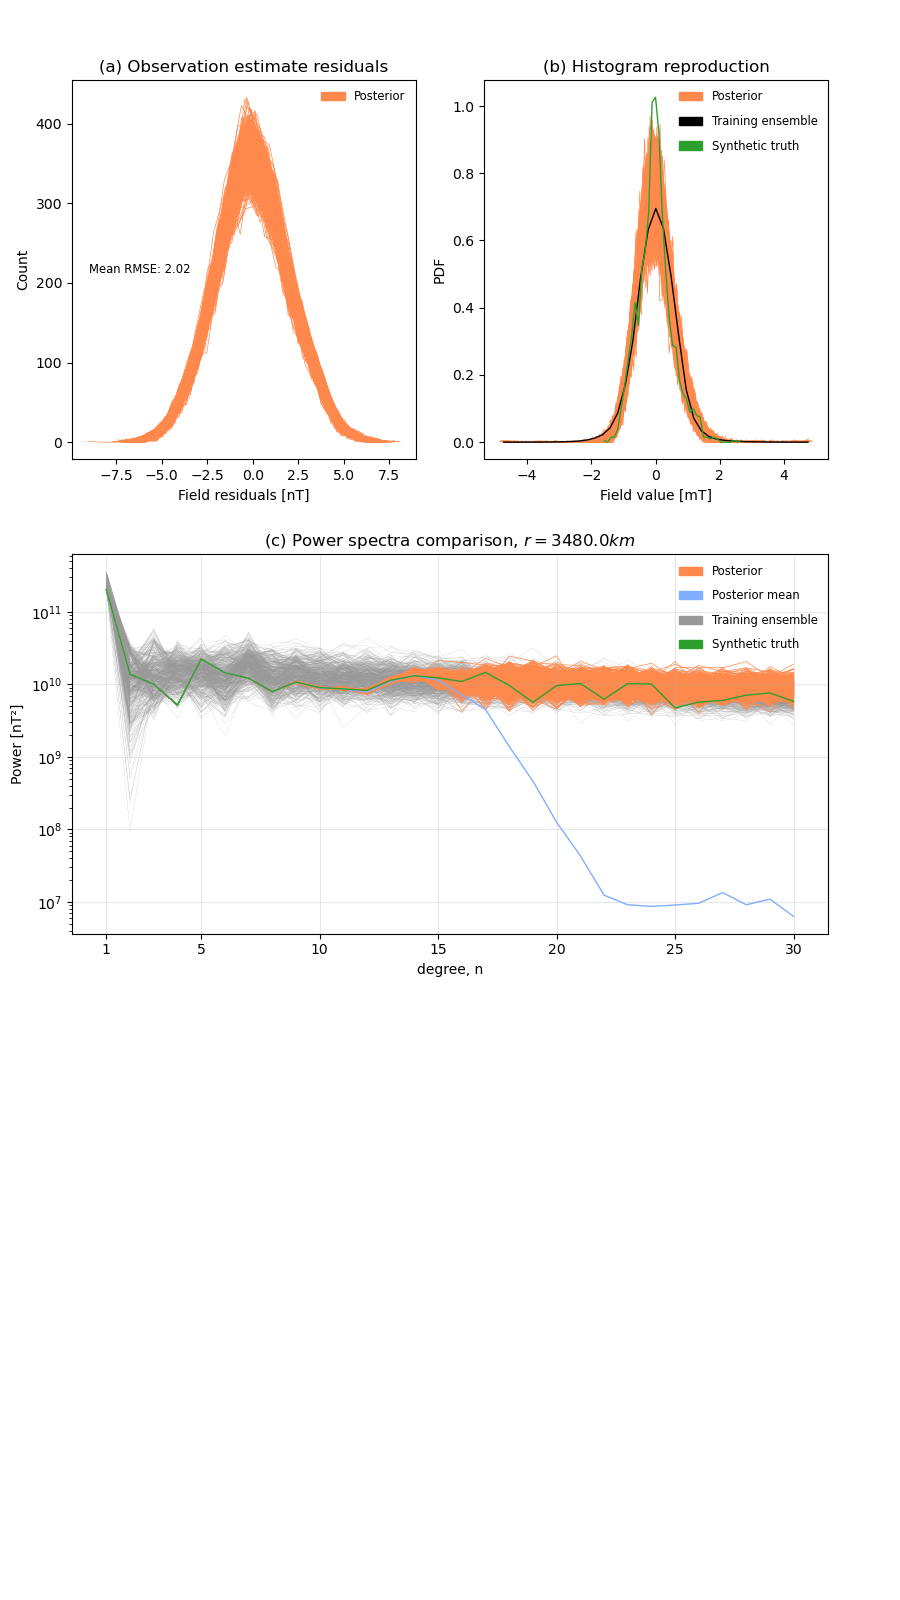

In [22]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

#truth_obj = s_source

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

mt_util.plot_sdssim_reproduce(core, core.m_DSS_res, m_equiv_lsq = None, truth_obj = s_source,
                              lags_use = 1000, spec_r_at = core.r_cmb, spec_show_differences = False,
                              spec_ti_ens = True, lwidth = .5, label_fontsize = "small",
                              res_use = True, sv_use = False, unit_field = "[mT]",
                              unit_transform_n_to_m = True, patch_legend = True, ens_prior = True,
                              model_dict = {}, figsize=(9,16), hist_ti_ens = True, hist_density = True,
                              hist_bins = 41, res_bins = 21, hist_pos_mean = False,
                              left=0.08, bottom=0.12, right=0.92, top=0.95, wspace = 0.2, hspace=0.25,
                              savefig = False, save_string = "case_core_synthetic", save_dpi = 300, 
                              save_path = "images/")

In [23]:
#core.grid_glq(nmax = 256, r_at = core.r_cmb)
#core.grid_glq(nmax = 120, r_at = core.r_cmb)
core.grid_glq(nmax = 400, r_at = core.r_cmb)

set_nmax = shc_grid

core.ensemble_B(core.g_spec, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_eqa = core.B_ensemble[:,0,:].copy()

#core.g_spec_mean = np.mean(core.g_spec,axis=1)
core.ensemble_B(core.g_spec_mean, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_mean_eqa = core.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
core.ensemble_B(s_sat.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
prior_eqa = core.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_lsq_equiv, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
#lsq_eqa = core.B_ensemble[:,0].copy()

<IPython.core.display.Javascript object>


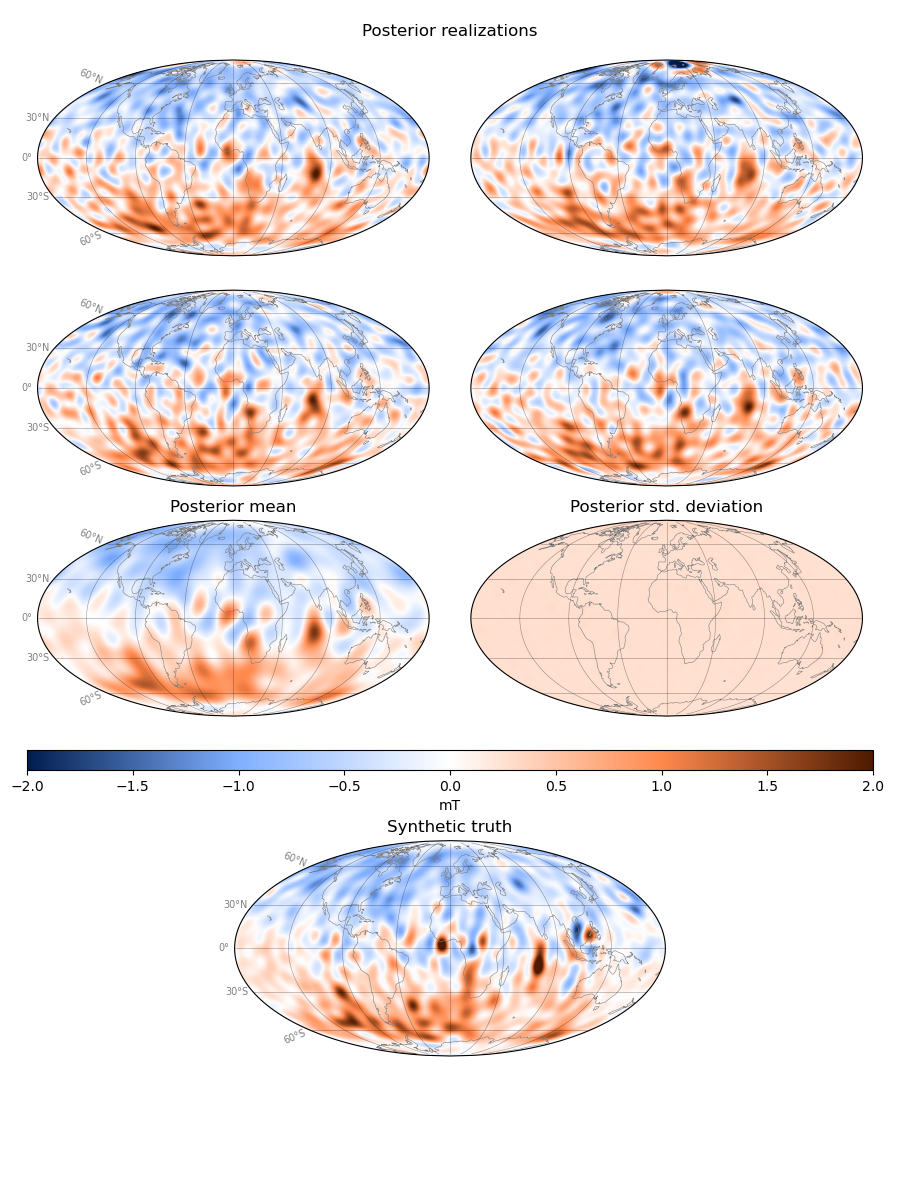

In [27]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(core.grid_phi, 90-core.grid_theta, zs_eqa, 
                        field_compare = prior_eqa, field_lsq = None, field_mean = zs_mean_eqa,
                        tile_size_row = 3, tile_size_column = 2, 
                        figsize=(9,12), limit_for_SF = 10**6, point_size = 0.1, cbar_limit = [-2,2],
                        coast_width = 0.4, coast_color = "grey", unit_transform_n_to_m = True,
                        cbar_h = 0.1, cbar_text = "mT", cbar_text_color = "black",
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.25, 
                        savefig = False, save_string = "case_core_synthetic", 
                        projection = ccrs.Mollweide(), use_gridlines = True, 
                        gridlines_width = 0.4, gridlines_alpha = 0.4, save_dpi = 100,
                        save_path = "images/")


# Local distribution map

<IPython.core.display.Javascript object>


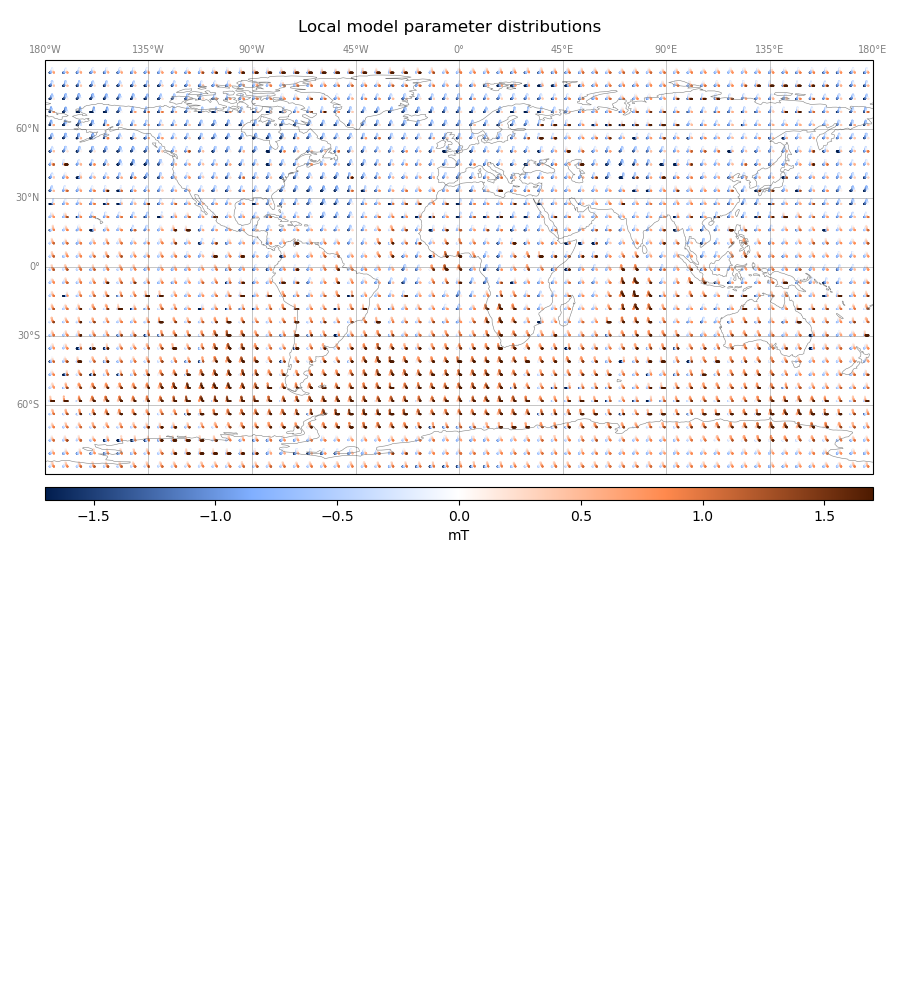

In [17]:
core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

skip = 1
m_skip = core.m_DSS[:,:][0::skip]
lat_skip = core.lat[0::skip]
lon_skip = core.lon[0::skip]

N_bins = 51
m_centers = []
m_y = []
for i in np.arange(0,m_skip.shape[0]):
    y,binEdges=np.histogram(m_skip[i,:],bins=N_bins)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    
    m_centers.append(bincenters)
    m_y.append(y)
m_centers = np.array(m_centers)
m_y = np.array(m_y)

deg_range = 1
lat_skip_lin = np.linspace(lat_skip-deg_range,lat_skip+deg_range,N_bins)
lon_skip_lin = np.linspace(lon_skip-1*deg_range,lon_skip+1*deg_range,N_bins)

m_y_scaled = []
for i in np.arange(0,m_skip.shape[0]):
    scale = np.min(lat_skip_lin[:,i]) + (m_y[i,:]-np.min(m_y[i,:]))*(np.max(lat_skip_lin[:,i])-np.min(lat_skip_lin[:,i]))/(np.max(m_y[i,:])-np.min(m_y[i,:]))
    m_y_scaled.append(scale)
m_y_scaled = np.array(m_y_scaled)

local_lat = m_y_scaled.reshape(-1,)
local_lon = lon_skip_lin.T.reshape(-1,)
local_data = m_centers.reshape(-1,)

# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
mt_util.plot_global(lat = local_lat, lon = local_lon, data = local_data, limits_data = [-1.7, 1.7],
                cbar_h = 0.03, cbar_mm_factor = 1, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(9,10), coast_width = 0.4,
                bottom=0.5, top=0.95, hspace=0.01, left = 0.05,
                title='Local model parameter distributions', point_size=0.1, projection_transformation = "PlateCarree",
                savefig = False, save_dpi = 100, save_string ="core_sh30_newTI_loc_mod_dist",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

[915, 1225, 480, 215]


<IPython.core.display.Javascript object>


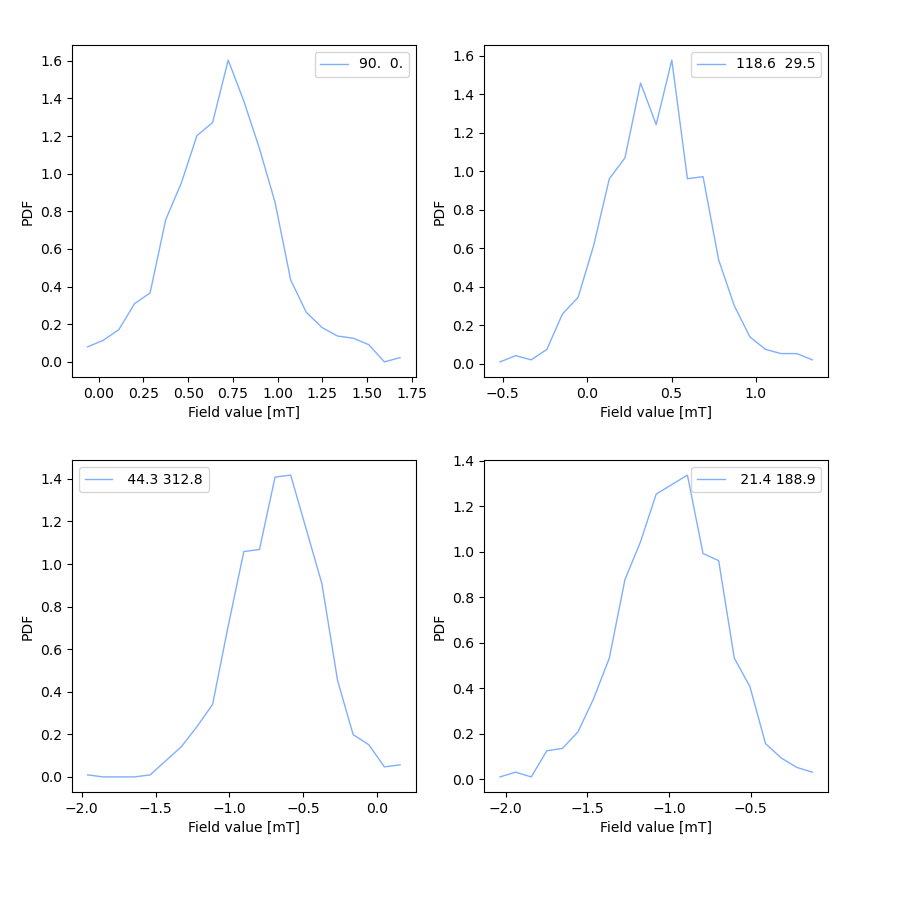

In [21]:
core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

list_coord = np.array([[0,2], [-30,30], [45,-45], [70,-170]])
list_coord[:,0] = 90 - list_coord[:,0]
list_coord[:,1][list_coord[:,1]<0.0] = 360 + list_coord[:,1][list_coord[:,1]<0.0]

m_coord_sph = np.hstack((90 - core.lat.reshape(-1,1), core.lon.reshape(-1,1)))

idx_min = []
for coord in list_coord:
    idx_min.append(np.sum(np.abs(m_coord_sph - coord),axis=1).argmin())
    
print(idx_min)

m_hists_coord = m_coord_sph[idx_min]
m_hists = core.m_DSS[idx_min,:]


left=0.08
bottom=0.12
right=0.92
top=0.95
wspace = 0.2
hspace=0.25

color_rgb_zesty_pos = (1.0,  0.5372549019607843,  0.30196078431372547)
color_rgb_zesty_neg = (0.5019607843137255,  0.6862745098039216,  1.0)


m_hists_scale = m_hists*10**(-6)
tile_size_row = 2
tile_size_column = 2
label_fontsize = 10

fig = plt.figure(figsize=(9,9)) # Initiate figure with constrained layout
# Generate ratio lists
h_ratio = [1]*tile_size_row
w_ratio = [1]*tile_size_column
gs = fig.add_gridspec(tile_size_row, tile_size_column, height_ratios=h_ratio, width_ratios=w_ratio) # Add x-by-y grid

for i in np.arange(0,list_coord.shape[0]):

    ax = fig.add_subplot(gs[i])
    
    y,binEdges=np.histogram(m_hists_scale[i,:],bins=21,density=True)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])    
    ax.plot(bincenters, y, '-', color = color_rgb_zesty_neg, 
            label='{}'.format(str(np.round(m_hists_coord[i,:],decimals=1))).lstrip('[').rstrip(']'),
            linewidth = 1)

    #ax.set_title('test')
    #ax.annotate("test", (0.05, 0.5), xycoords='axes fraction', va='center', fontsize = label_fontsize)
    ax.set_xlabel("Field value [mT]")
    ax.set_ylabel("PDF")
    ax.legend(loc='best', fontsize = label_fontsize)
    

fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)